# Tissue Detection
Last updated: 08/14/2023

Use low resolution WSIs from Emory & UC Davis and their tissue mask (created by HistomicsTK tissue detection function and curated by JC) to train a semantic segmentation model (DeepLabV3) to predict tissue regions in WSIs.

In [108]:
# Imports
import sys
sys.path.append('../..')

from glob import glob
from os.path import isfile
from pandas import DataFrame, read_csv
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

from neurotk import imread
from neurotk.utils import replace_last_occurence
from neurotk.torch import EarlyStopping, train_binary_ss_model
from neurotk.torch.datasets import BinarySSDataset
from neurotk.torch.models import deeplabv3_model
from neurotk.torchvision.semantic_segmentation_transforms import (
    Normalize, ToTensor, Resize, RandomHorizontalFlip, RandomVerticalFlip,
    RandomRotation, ColorJitter, Compose
)
from neurotk.torchvision.transforms import UnNormalize
from neurotk.torch.metrics import binary_dice_coefficient

import torch
from torch.utils.data import DataLoader

from torchvision.utils import make_grid
import torchvision.transforms.functional as F

In [5]:
# Create CSV / load DataFrame for the tissue detection dataset*.
# * We use the dataset created in the YOLO Braak Stage project for WSI 
# inference.
dataset_csv_fp = '/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detection/' + \
                 'tissue-dataset.csv'  # file path to CSV file

if isfile(dataset_csv_fp):
    dataset_df = read_csv(dataset_csv_fp)
else:
    dataset_df = []
    
    # Loop through all the images.
    for img_fp in glob('/jcDataStore/Data/nft-ai-project/wsi-inference/'
                       'tissue-masks/images/*.png'):
        # Read image.
        img = imread(img_fp)           
        
        # Get path to image label, always located in parallel path, in "masks" 
        # directory.
        label_fp = replace_last_occurence(img_fp, '/images/', '/masks/', 
                                          required=True)
    
        # Label file must exist.
        if not isfile(label_fp):
            raise FileExistsError(f'Label file ({label_fp}) does not exist.')
    
        dataset_df.append([img_fp, label_fp])
    
    dataset_df = DataFrame(dataset_df, columns=['fp', 'label'])
    dataset_df.to_csv(dataset_csv_fp, index=False)

dataset_df.head()

,fp,label
0,/jcDataStore/Data/nft-ai-project/wsi-inference...,/jcDataStore/Data/nft-ai-project/wsi-inference...
1,/jcDataStore/Data/nft-ai-project/wsi-inference...,/jcDataStore/Data/nft-ai-project/wsi-inference...
2,/jcDataStore/Data/nft-ai-project/wsi-inference...,/jcDataStore/Data/nft-ai-project/wsi-inference...
3,/jcDataStore/Data/nft-ai-project/wsi-inference...,/jcDataStore/Data/nft-ai-project/wsi-inference...
4,/jcDataStore/Data/nft-ai-project/wsi-inference...,/jcDataStore/Data/nft-ai-project/wsi-inference...


In [6]:
# Parameters
batch_size = 8
epochs = 50
val_frac = 0.1  # fraction of images to set as validation
random_state = 64  # set to None to keep it random
lr = 1e-4  # learning rate, something small like 1e-4
device = None  # will default to first GPU or CPU if not available
size = 256  # size of image to train with

# Color normalization mean and standard deviation to use with LabView.
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

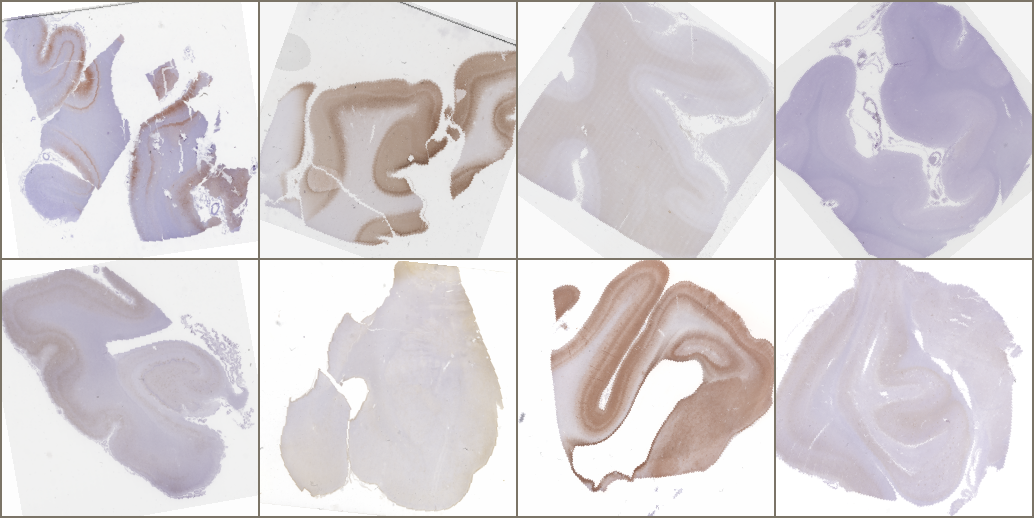

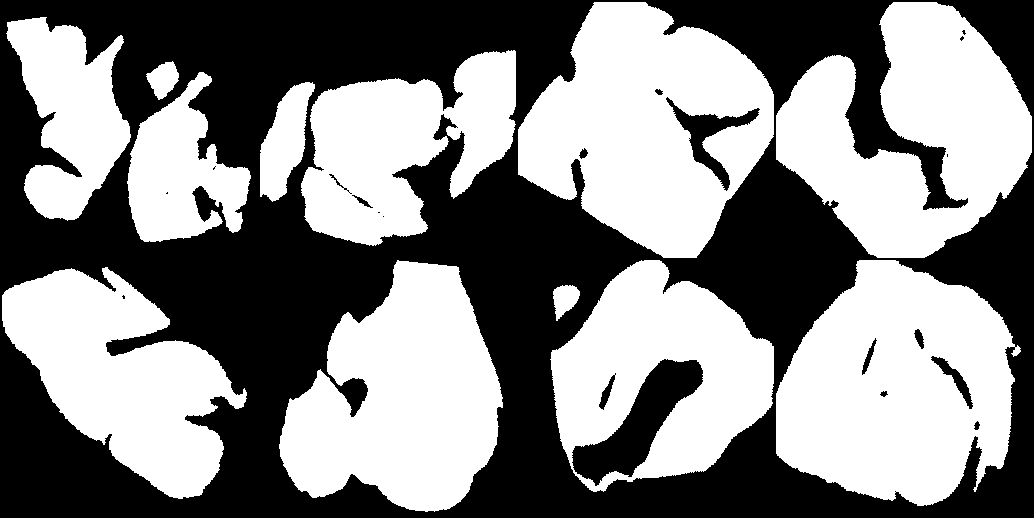

In [52]:
# Create dataloaders.
train_df, val_df = train_test_split(dataset_df, test_size=val_frac, 
                                    random_state=random_state)

# Data augmentation transforms.
transforms = Compose([
    ToTensor(), 
    Resize((size, size)), 
    RandomHorizontalFlip(), 
    RandomVerticalFlip(), 
    RandomRotation(90, fill=1),
    ColorJitter(brightness=0.1, contrast=0.005, saturation=0.2, hue=0.02),
    Normalize(mean=norm_mean, std=norm_std)
])

val_transforms = Compose([
    ToTensor(),
    Resize((size, size)),
    Normalize(mean=norm_mean, std=norm_std)
])

# Create dataloaders, set as dictionary with 'train' and 'val'.
dataloaders = {
    'train': DataLoader(
        BinarySSDataset(train_df, transforms=transforms), 
        batch_size=batch_size, 
        shuffle=True
    ),
    'val': DataLoader(
        BinarySSDataset(val_df, transforms=val_transforms), 
        batch_size=batch_size, 
        shuffle=False
    )
}

# Visualize a batch from the training dataset.
sample = next(iter(dataloaders['train']))
img_grid = make_grid(sample['image'], nrow=4)

unorm = UnNormalize(mean=norm_mean, std=norm_std)
img_grid = unorm(img_grid)

F.to_pil_image(img_grid).show()

mask_grid = make_grid(sample['mask'], nrow=4)
F.to_pil_image(mask_grid).show()

In [12]:
# Create model.
model = deeplabv3_model()

# Optimizer gets fed in the model parameters and learning rate.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Specify the loss function
criterion = torch.nn.MSELoss(reduction='mean')

# Set up the metrics
metrics = {'dice coefficient': binary_dice_coefficient()}

In [14]:
model = train_binary_ss_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    metrics,
    epochs=5,
    device=device,
    early_stopper=EarlyStopping(),
    # save_dir='/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detection/models/test'
)

Epoch 1 of 5
------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:41<00:00,  1.47it/s]


(train) loss: 0.0109, dice coefficient: 0.8723


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.36it/s]


(val) loss: 0.0087, dice coefficient: 0.9362
Early stopping value change (0.0087)

Epoch 2 of 5
------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:40<00:00,  1.50it/s]


(train) loss: 0.0045, dice coefficient: 0.9040


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


(val) loss: 0.0047, dice coefficient: 0.9434
Early stopping value change (0.0047)

Epoch 3 of 5
------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:41<00:00,  1.48it/s]


(train) loss: 0.0039, dice coefficient: 0.9201


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]


(val) loss: 0.0041, dice coefficient: 0.9477
Early stopping value change (0.0041)

Epoch 4 of 5
------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:40<00:00,  1.49it/s]


(train) loss: 0.0036, dice coefficient: 0.9265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]


(val) loss: 0.0044, dice coefficient: 0.9391
No change in early stopping value for 1 epochs.

Epoch 5 of 5
------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:40<00:00,  1.50it/s]


(train) loss: 0.0033, dice coefficient: 0.9299


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]


(val) loss: 0.0040, dice coefficient: 0.9450
Early stopping value change (0.0040)



## Load model and predict on an image.

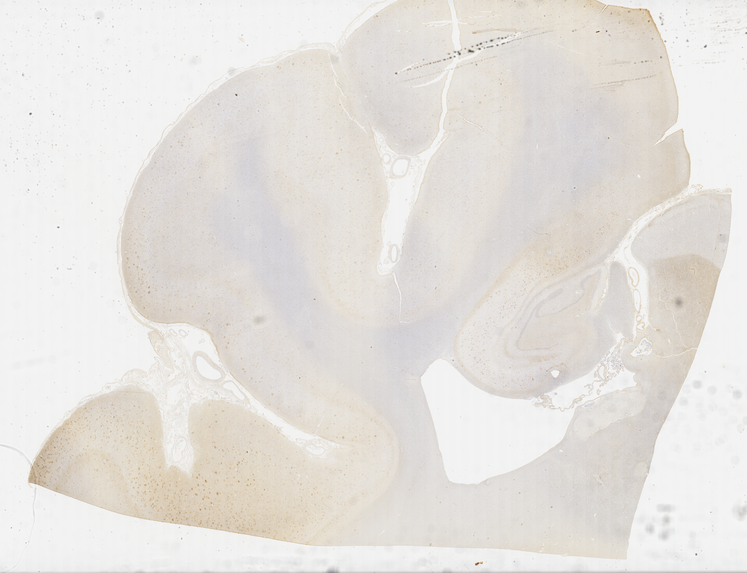

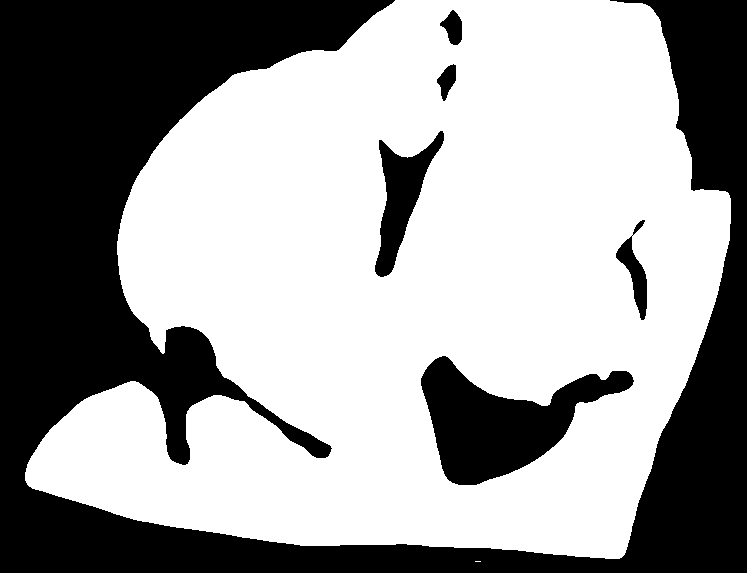

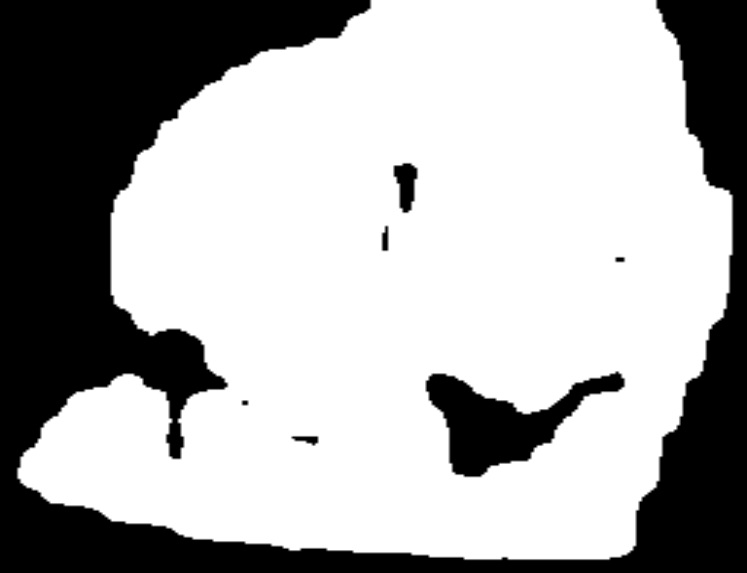

In [113]:
# Get a blank model.
model = deeplabv3_model()

# Load the weights.
model.load_state_dict(torch.load(
    '/jcDataStore/Data/NeuroTK-Dash/ml-tissue-detection/models/test/best.pt'    
))

# Prevent weights from adjusting.
model.eval()

# Read an image to predict on.
img = Image.open('/jcDataStore/Data/nft-ai-project/wsi-inference/tissue-masks/images/1023340.png')
orig_shape = img.size
img.show()

# Read its mask.
true = Image.open('/jcDataStore/Data/nft-ai-project/wsi-inference/tissue-masks/masks/1023340.png')
true.show()

# Apply transform to image before predicting.
img, _ = val_transforms(img, true)

# Predict the mask
with torch.set_grad_enabled(False):
    img = img.unsqueeze(0)
    pred = model(img)['out']

# Visualize the prediction.
pred = (pred[0][0] > 0.1).data.cpu().numpy()

# Lets reshape to original size.
pred = pred.astype(np.uint8) * 255
pred = cv.resize(pred, orig_shape, None, None, cv.INTER_NEAREST)
Image.fromarray(pred).show()